In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [8]:
def layers_indexing(geo_df):
    bh_dict = {bh:1 for bh in geo_df["PointID"].unique()}
    pointid = geo_df["PointID"].to_list()
    index = []
    for bh in pointid:
        index.append(bh_dict[bh])
        bh_dict[bh] += 1
    geo_df["Index"] = index
    return geo_df

def find_index(geo_df, bh, depth):
    try: 
        filtered_df = geo_df[geo_df["PointID"] == bh]
        bottom_depth = filtered_df["Depth"].iloc[-1]
        for index, row in filtered_df.iterrows():
            if depth >= row["Top depth"] and depth < row["Depth"]:
                ind = row["Index"]
            elif depth == bottom_depth:
                ind =  bottom_depth = filtered_df["Index"].iloc[-1]
                break
        return ind
    except Exception as e:
        print("find_index", bh, depth, e)
        return "error"
    
def convert_BH(bh):
    if "DTHCPT" in bh:
        bh = "544WTG23-BH03"
    else:
        bh = bh.replace("CPT", "BH")
        bh = bh[:13]
    return bh

def CPT_parameters(qc, fs, u2, ts, ve):
    try: 
        a = 0.8
        qc *= 1000
        fs *= 1000
        u2 *= 1000
        qnet = qc + u2*(1 -a)
        Rf = (fs/qnet)*100
        # Conditions for Qt to aviod math domain error
        if ve != 0: 
            Qt = (qnet - ts)/ve
        else:
            Qt = 0
            Ic = 0
        # Conditions for Ic to aviod math domain error
        if Rf > 0 and Qt > 0:
            Ic = ((3.47 - math.log(Qt))**2 + (math.log(Rf) + 1.22)**2)**0.5
        else:
            Ic = 0
        qn = qnet - ts
        delta_u = u2 - (ts - ve)
        Bq = delta_u/qn
        return qnet, Rf, Qt, Bq, Ic
    except Exception as e:
        print(Qt, Rf, e)
    
def effective_stress(geo_df, bh, depth, index):
    # Filtered the df by BH
    filtered_df = geo_df[geo_df["PointID"] == bh]
    try: 
        # Extract the values
        cum_BD = filtered_df.loc[filtered_df.Index == index, "Cum BD (kn/m3)"].values[0]
        layer_depth = filtered_df.loc[filtered_df.Index == index, "Top depth"].values[0]
        layer_BD = filtered_df.loc[filtered_df.Index == index, "Mean BD (kn/m3)"].values[0]
        water_depth = 42.5
        total_stress = cum_BD + (depth - layer_depth) * layer_BD + 9.8*water_depth
        pwp = (depth+water_depth)*9.8
        ve = total_stress - pwp
        return total_stress, ve
    except Exception as e:
        print(bh, depth, index, e)
        return "Error"

def calculate_su(qnet, ve):
    nkt = 14
    su = (qnet - ve) / nkt
    return su

def calculate_ocr(Qt, Ic):
    if Qt <= 0 or Qt > 20 or Ic < 2.05 or Ic > 3.6 :
        return 0, 0
    else:
        ocr_rob = 0.25 * (Qt)**1.25
        k = 0.33
        ocr_mayne = k * Qt
        return ocr_rob, ocr_mayne

def borehole_plots(df, parameter, c):
    borehole_list = df["PointID"].unique()
    bh = 0
    fig, axes = plt.subplots(3, 4)
    fig.suptitle(f'Distribution of {parameter} by geological layers', size=30, x=0.5, y=0.92)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    sns.set(rc={"figure.figsize":(20, 27)})
    sns.set(font_scale=1) 
    for row in range(3):
        for col in range(4):
            if bh >= len(borehole_list):
                pass
            else:
                filtered_df = df[df["PointID"] == borehole_list[bh]]
                ax = sns.stripplot(data=filtered_df, x=parameter, y="Index", ax=axes[row, col], orient="h", color=c, 
                                   jitter=False, s=10, marker="D", linewidth=1, alpha=.1)
                ax = sns.boxplot(data=filtered_df, x=parameter, y="Index", ax=axes[row, col], orient="h", boxprops=dict(alpha=.7), linewidth=1, showfliers= False)
                ax.set_title(borehole_list[bh], size=16)
                ax.set_ylabel("Layers")
                bh += 1

def calculate_QNC(Qt, PI, LL):
    if PI < 9:
        qnc = 23.18 - 2.36*PI
    elif PI < 65:
        qnc = 3.98-0.031*PI
    if PI > 14:
        mCPTu = 0.021*PI + 0.48
    else:
        mCPTu = 0.8
    OCR = (Qt/qnc)**(mCPTu)
    
    # Liquid limit
    if LL < 32:
        qnc_LL = 5.9 * (LL - 25) - 45.6
    elif 32 <= LL <= 100:
        qnc_LL = 3.69 - 0.019 * (LL - 25)
    else:
        return None
    
    
    return qnc, mCPTu, OCR

In [9]:
geo_df = pd.read_excel("data/BD profile_update.xlsx")
cpt_df = pd.read_excel("data/CPT data_raw.xlsx")
cpt_df

,Unnamed: 0,PointID,CPT_hole,Depth (m),qc (MPa),fs (MPa),Inc. NS,Inc EW,u2 (MPa),time (s)
0,0,544WTG23-BH10,CPT10,0.00000,0.003214,0.0,-0.425142,0.372760,0.000597,-3120.19
1,1,544WTG23-BH10,CPT10,0.01000,0.003214,0.0,-1.389042,-0.696828,0.000597,-3119.19
2,2,544WTG23-BH10,CPT10,0.02000,0.003214,0.0,-0.095290,0.021505,0.000597,-3118.53
3,3,544WTG23-BH10,CPT10,0.03000,0.003214,0.0,-0.197911,0.881720,0.000597,-3117.88
4,4,544WTG23-BH10,CPT10,0.04000,0.003214,0.0,-0.535092,0.777778,0.000597,-3117.22
...,...,...,...,...,...,...,...,...,...,...
46587,46587,544WTG23-BH11,CPT11,14.61024,45.343010,0.0,0.163881,-2.779262,-6.816239,6575.36
46588,46588,544WTG23-BH11,CPT11,14.62024,45.557530,0.0,0.175762,-3.620167,-1.474359,6575.95
46589,46589,544WTG23-BH11,CPT11,14.63024,51.760460,0.0,0.229843,-3.841083,-2.784900,6576.51
46590,46590,544WTG23-BH11,CPT11,14.64024,37.670360,0.0,0.188463,-3.734188,-1.509972,6577.09


In [10]:
cpt_df["Index"] = cpt_df.apply(lambda x: find_index(geo_df, x.PointID, x["Depth (m)"]), axis=1)
cpt_df = cpt_df[(cpt_df["PointID"] != "544WTG23-BH03") & (cpt_df["PointID"] != "544WTG23-BH08") & (cpt_df["PointID"] != "544WTG23-DTHCPT03b")].copy()  # filter out the two bh where BD profile is incomplete
cpt_df[["σv (kPa)", "σ'v (kPa)"]] = cpt_df.apply(lambda x: effective_stress(geo_df, x.PointID, x["Depth (m)"], x.Index), axis=1, result_type="expand")
cpt_df

,Unnamed: 0,PointID,CPT_hole,Depth (m),qc (MPa),fs (MPa),Inc. NS,Inc EW,u2 (MPa),time (s),Index,σv (kPa),σ'v (kPa)
0,0,544WTG23-BH10,CPT10,0.00000,0.003214,0.0,-0.425142,0.372760,0.000597,-3120.19,1,416.50000,0.000000
1,1,544WTG23-BH10,CPT10,0.01000,0.003214,0.0,-1.389042,-0.696828,0.000597,-3119.19,1,416.68718,0.089180
2,2,544WTG23-BH10,CPT10,0.02000,0.003214,0.0,-0.095290,0.021505,0.000597,-3118.53,1,416.87436,0.178360
3,3,544WTG23-BH10,CPT10,0.03000,0.003214,0.0,-0.197911,0.881720,0.000597,-3117.88,1,417.06154,0.267540
4,4,544WTG23-BH10,CPT10,0.04000,0.003214,0.0,-0.535092,0.777778,0.000597,-3117.22,1,417.24872,0.356720
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46587,46587,544WTG23-BH11,CPT11,14.61024,45.343010,0.0,0.163881,-2.779262,-6.816239,6575.36,4,689.75075,130.070398
46588,46588,544WTG23-BH11,CPT11,14.62024,45.557530,0.0,0.175762,-3.620167,-1.474359,6575.95,4,689.94199,130.163638
46589,46589,544WTG23-BH11,CPT11,14.63024,51.760460,0.0,0.229843,-3.841083,-2.784900,6576.51,4,690.13323,130.256878
46590,46590,544WTG23-BH11,CPT11,14.64024,37.670360,0.0,0.188463,-3.734188,-1.509972,6577.09,4,690.32447,130.350118


In [11]:
cpt_df[["qnet (kPa)", "Rf", "Qt (kPa)", "Bq", "Ic"]] = cpt_df.apply(lambda x: CPT_parameters(x["qc (MPa)"], x["fs (MPa)"], x["u2 (MPa)"], x["σv (kPa)"], x["σ'v (kPa)"]),
                                                              axis=1, result_type="expand")

In [12]:
cpt_df["Su"] = cpt_df.apply(lambda x: calculate_su(x["qnet (kPa)"], x["σv (kPa)"]), axis=1)
cpt_df[["OCR Robertson", "OCR Mayne"]] = cpt_df.apply(lambda x: calculate_ocr(x["Qt (kPa)"], x.Ic), axis=1, result_type="expand")
cpt_df["Su/σ'v"] = cpt_df["Su"]/cpt_df["σ'v (kPa)"]
cpt_df[["Qnc", "mCPTu"]] = cpt_df.apply(lambda x: calculate_ocr(x["Qt (kPa)"], x.Ic), axis=1, result_type="expand")
cpt_df

,Unnamed: 0,PointID,CPT_hole,Depth (m),qc (MPa),fs (MPa),Inc. NS,Inc EW,u2 (MPa),time (s),...,Rf,Qt (kPa),Bq,Ic,Su,OCR Robertson,OCR Mayne,Su/σ'v,Qnc,mCPTu
0,0,544WTG23-BH10,CPT10,0.00000,0.003214,0.0,-0.425142,0.372760,0.000597,-3120.19,...,0.0,0.000000,1.006624,0.0,-29.511864,0.0,0.0,-inf,0.0,0.0
1,1,544WTG23-BH10,CPT10,0.01000,0.003214,0.0,-1.389042,-0.696828,0.000597,-3119.19,...,0.0,-4635.044658,1.006405,0.0,-29.525234,0.0,0.0,-331.074618,0.0,0.0
2,2,544WTG23-BH10,CPT10,0.02000,0.003214,0.0,-0.095290,0.021505,0.000597,-3118.53,...,0.0,-2318.571779,1.006186,0.0,-29.538604,0.0,0.0,-165.612270,0.0,0.0
3,3,544WTG23-BH10,CPT10,0.03000,0.003214,0.0,-0.197911,0.881720,0.000597,-3117.88,...,0.0,-1546.414153,1.005968,0.0,-29.551974,0.0,0.0,-110.458154,0.0,0.0
4,4,544WTG23-BH10,CPT10,0.04000,0.003214,0.0,-0.535092,0.777778,0.000597,-3117.22,...,0.0,-1160.335340,1.005750,0.0,-29.565344,0.0,0.0,-82.881096,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46587,46587,544WTG23-BH11,CPT11,14.61024,45.343010,0.0,0.163881,-2.779262,-6.816239,6575.36,...,0.0,332.819860,-0.170384,0.0,3092.143675,0.0,0.0,23.772847,0.0,0.0
46588,46588,544WTG23-BH11,CPT11,14.62024,45.557530,0.0,0.175762,-3.620167,-1.474359,6575.95,...,0.0,342.436006,-0.045636,0.0,3183.765444,0.0,0.0,24.459715,0.0,0.0
46589,46589,544WTG23-BH11,CPT11,14.63024,51.760460,0.0,0.229843,-3.841083,-2.784900,6576.51,...,0.0,387.797924,-0.066216,0.0,3608.096198,0.0,0.0,27.699852,0.0,0.0
46590,46590,544WTG23-BH11,CPT11,14.64024,37.670360,0.0,0.188463,-3.734188,-1.509972,6577.09,...,0.0,281.380959,-0.056436,0.0,2619.860081,0.0,0.0,20.098640,0.0,0.0


## Plot distribution

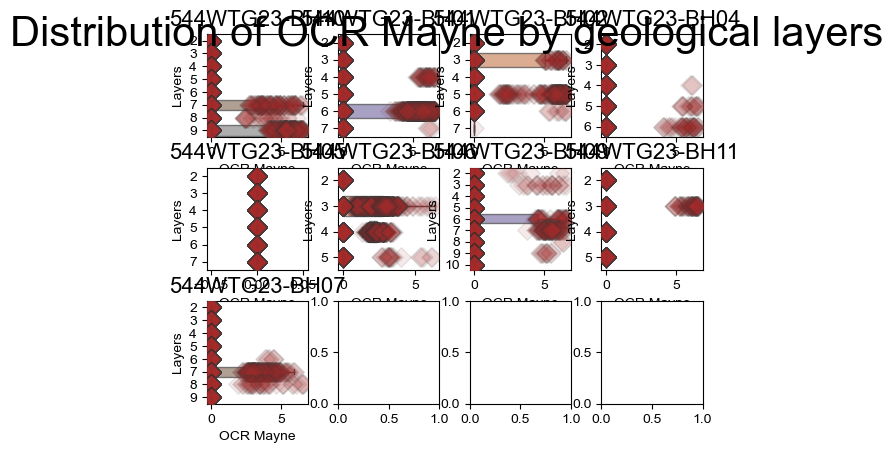

In [13]:
deep_df = cpt_df[cpt_df["Index"] != 1]
df, parameter, c = deep_df, "OCR Mayne", "brown"
borehole_list = df["PointID"].unique()
bh = 0
fig, axes = plt.subplots(3, 4)
fig.suptitle(f'Distribution of {parameter} by geological layers', size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 27)})
sns.set(font_scale=1) 
for row in range(3):
    for col in range(4):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = df[df["PointID"] == borehole_list[bh]]
            ax = sns.stripplot(data=filtered_df, x=parameter, y="Index", ax=axes[row, col], orient="h", color=c, 
                               jitter=False, s=10, marker="D", linewidth=1, alpha=.1)
            ax = sns.boxplot(data=filtered_df, x=parameter, y="Index", ax=axes[row, col], orient="h", boxprops=dict(alpha=.7), linewidth=1, showfliers= False)
            ax.set_title(borehole_list[bh], size=16)
            ax.set_ylabel("Layers")
            bh += 1

In [14]:
#cpt_df.to_excel("data/CPT parameter update.xlsx")